In [53]:
import pandas
import numpy
from scipy.stats import binom
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [52]:
url = ('https://github.com/dhesse/IN-STK5000-Autumn21'
       '/raw/main/compas-scores-two-years.csv.gz')
data = pandas.read_csv(url)

# Point Estimate

In [6]:
data.groupby('age_cat')['two_year_recid'].mean()

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

## Bootstrap

In [18]:
bss = pandas.DataFrame([
    data.sample(data.shape[0], replace=True).
    groupby('age_cat')['two_year_recid'].mean()
    for _ in range(10000)])

<AxesSubplot:ylabel='Frequency'>

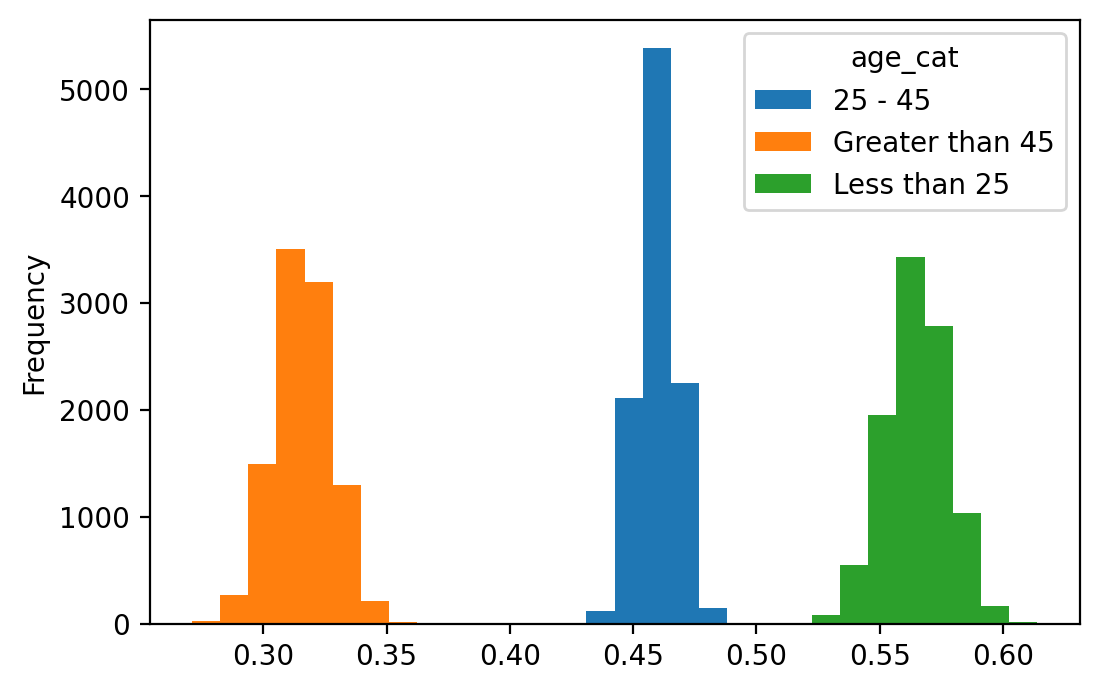

In [57]:
bss.plot.hist(bins=30)

## Binomial

In [9]:
params = pandas.DataFrame({
    'N': data.groupby('age_cat').size(),
    'k': data.groupby('age_cat')['two_year_recid'].sum(),
})

In [10]:
params

,N,k
age_cat,,
25 - 45,4109,1889
Greater than 45,1576,498
Less than 25,1529,864


In [11]:
params['k'] / params['N'] # point estimates from above

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
dtype: float64

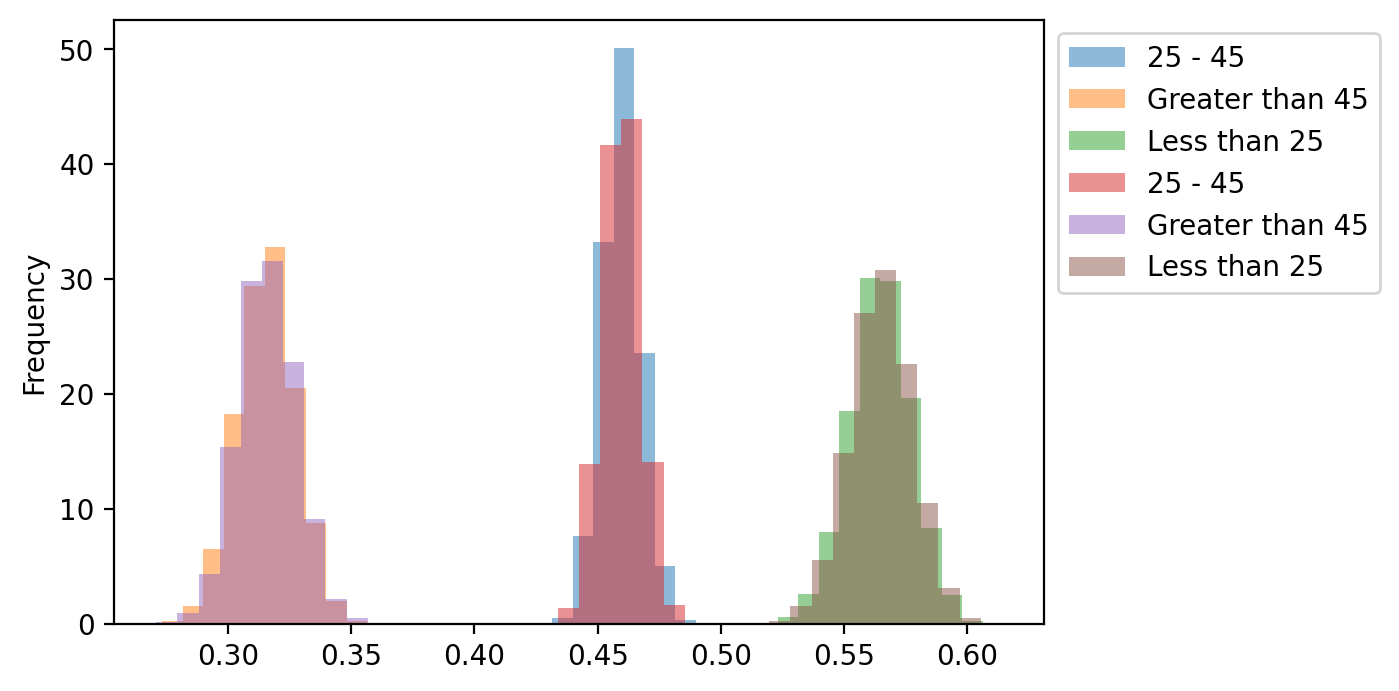

In [58]:
binomial = params.apply(
    lambda x: binom.rvs(x['N'],
                        x['k']/x['N'],
                        size=5000)/x['N'], axis=1, result_type='expand').T
ax = binomial.plot.hist(bins=40, density=True, alpha=0.5)
bss.plot.hist(bins=40, ax=ax, density=True, alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
X = pandas.get_dummies(data['age_cat'], drop_first=True)
y = data['two_year_recid']

In [45]:
X.columns

Index(['Greater than 45', 'Less than 25'], dtype='object')

In [52]:
m = LogisticRegression(penalty='none').fit(X, y)

In [53]:
m.coef_

array([[-0.61080397,  0.42324471]])

In [54]:
m.intercept_

array([-0.16145935])

In [49]:
p = data.groupby('age_cat')['two_year_recid'].mean()

In [55]:
p

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

In [56]:
numpy.log(p['25 - 45'] / (1 - p['25 - 45']))

-0.16145960736481563

In [57]:
numpy.log(p['Greater than 45'] / (1 - p['Greater than 45']) / p['25 - 45'] * (1 - p['25 - 45']))

-0.6108030670794741

In [58]:
df = X.join(y)

In [59]:
feat = X.columns

In [62]:
coef, intercept = [], []
for _ in range(500):
    sample = df.sample(df.shape[0], replace=True)
    m = LogisticRegression(penalty='none').fit(sample[feat], sample['two_year_recid'])
    coef.append(m.coef_[0])
    intercept.append(m.intercept_[0])

(array([  6.,  12.,  43.,  90., 112., 111.,  76.,  33.,  14.,   3.]),
 array([-0.25312259, -0.23437725, -0.2156319 , -0.19688656, -0.17814121,
        -0.15939587, -0.14065052, -0.12190518, -0.10315983, -0.08441449,
        -0.06566914]),
 <BarContainer object of 10 artists>)

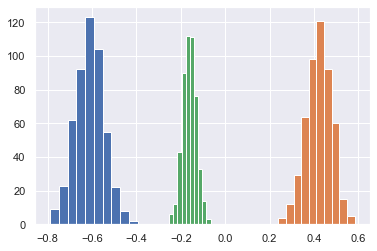

In [63]:
plt.hist(numpy.array(coef)[:,0])
plt.hist(numpy.array(coef)[:,1])
plt.hist(intercept)

(array([ 0.64015893,  1.28031785,  4.58780564,  9.60238389, 11.94963329,
        11.84294013,  8.10867973,  3.52087409,  1.49370416,  0.32007946]),
 array([-0.25312259, -0.23437725, -0.2156319 , -0.19688656, -0.17814121,
        -0.15939587, -0.14065052, -0.12190518, -0.10315983, -0.08441449,
        -0.06566914]),
 <BarContainer object of 10 artists>)

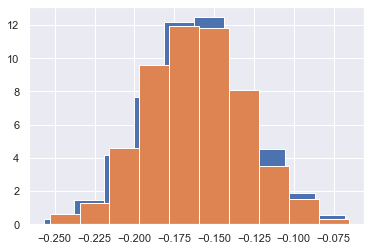

In [69]:
plt.hist(numpy.log(bss['25 - 45'] / (1 - bss['25 - 45'])), density=True)
plt.hist(intercept, density=True)